# IDM Price Prediction vs Actual Analysis

This notebook compares predicted IDM prices against actual IDM prices across different years.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Define metrics functions to replace sklearn
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

## Data Loading and Processing

In [2]:
# Load and process data for each year
years = [2021, 2022, 2023, 2024]
all_data = []

for year in years:
    # Load predicted IDM prices - all in FINAL MODEL directory
    pred_file = f'FINAL MODEL/predicted_idm_prices_{year}_from_{year}dam.csv'
    
    # Load actual IDM prices
    actual_file = f'Cleaned market prices/DAM & IDM/{year} DAM IDM Price.csv'
    
    try:
        # Read predicted data
        pred_df = pd.read_csv(pred_file)
        pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
        
        # Read actual data  
        actual_df = pd.read_csv(actual_file)
        actual_df['Date (UK)'] = pd.to_datetime(actual_df['Date (UK)'], format='%d/%m/%Y %H:%M')
        
        # Merge on datetime
        merged = pd.merge(pred_df, actual_df, 
                         left_on='datetime', right_on='Date (UK)', 
                         how='inner')
        
        merged['year'] = year
        merged['predicted_idm'] = merged['Predicted_IDM']
        merged['actual_idm'] = merged['IDM price']
        
        all_data.append(merged[['datetime', 'year', 'predicted_idm', 'actual_idm']])
        print(f"Loaded {len(merged)} records for {year}")
        
    except FileNotFoundError as e:
        print(f"File not found for {year}: {e}")
    except Exception as e:
        print(f"Error loading {year}: {e}")

# Combine all years
df = pd.concat(all_data, ignore_index=True)
print(f"\nTotal records: {len(df)}")
print(f"Years covered: {sorted(df['year'].unique())}")

Loaded 8758 records for 2021
Loaded 8758 records for 2022
Loaded 8758 records for 2023
Loaded 8784 records for 2024

Total records: 35058
Years covered: [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


## Summary Statistics by Year

In [3]:
# Calculate performance metrics by year
metrics_by_year = []

for year in sorted(df['year'].unique()):
    year_data = df[df['year'] == year]
    
    mae = mean_absolute_error(year_data['actual_idm'], year_data['predicted_idm'])
    rmse = np.sqrt(mean_squared_error(year_data['actual_idm'], year_data['predicted_idm']))
    r2 = r2_score(year_data['actual_idm'], year_data['predicted_idm'])
    
    metrics_by_year.append({
        'Year': year,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Records': len(year_data)
    })

metrics_df = pd.DataFrame(metrics_by_year)
print("Performance Metrics by Year:")
print(metrics_df.round(3))

Performance Metrics by Year:
   Year     MAE    RMSE     R²  Records
0  2021  21.873  58.171  0.573     8758
1  2022  34.335  53.607  0.745     8758
2  2023  15.334  21.432  0.709     8758
3  2024  10.622  15.997  0.733     8784


## Visualization: Predicted vs Actual IDM Prices

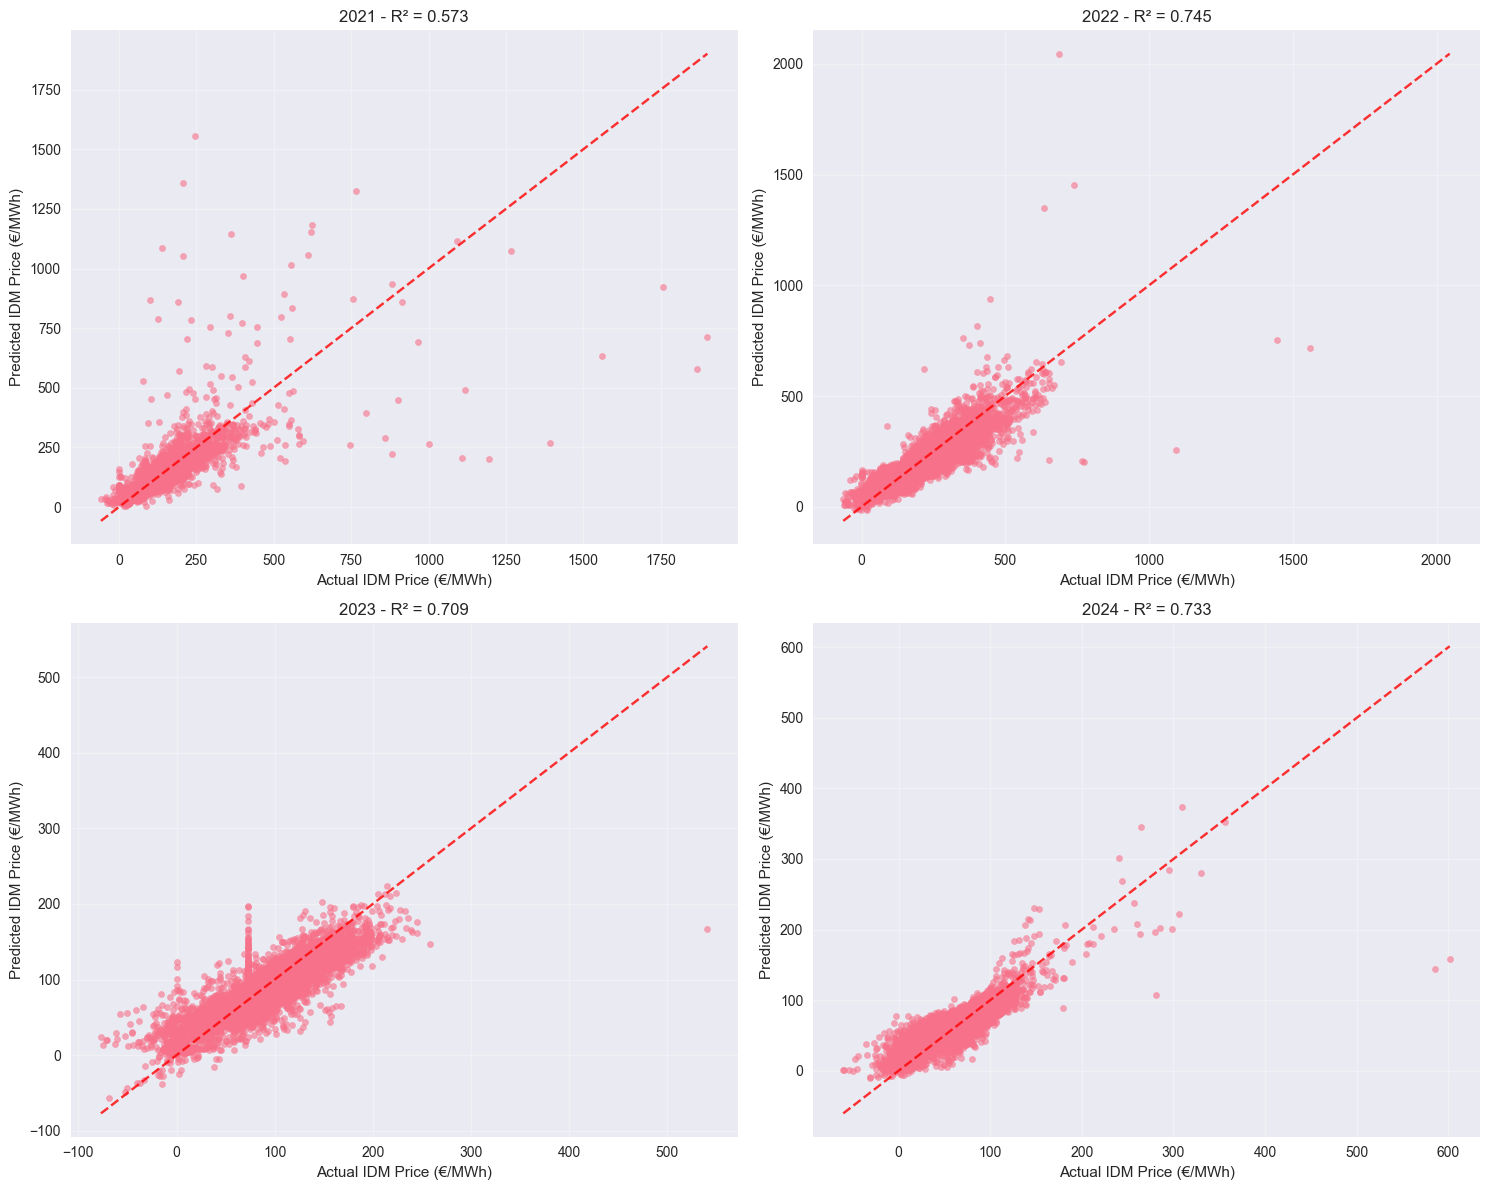

In [4]:
# Create scatter plot for each year
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, year in enumerate(sorted(df['year'].unique())):
    year_data = df[df['year'] == year]
    
    axes[i].scatter(year_data['actual_idm'], year_data['predicted_idm'], 
                   alpha=0.6, s=20)
    
    # Perfect prediction line
    min_val = min(year_data['actual_idm'].min(), year_data['predicted_idm'].min())
    max_val = max(year_data['actual_idm'].max(), year_data['predicted_idm'].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    
    axes[i].set_xlabel('Actual IDM Price (€/MWh)')
    axes[i].set_ylabel('Predicted IDM Price (€/MWh)')
    axes[i].set_title(f'{year} - R² = {metrics_df[metrics_df["Year"]==year]["R²"].iloc[0]:.3f}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Time Series Comparison

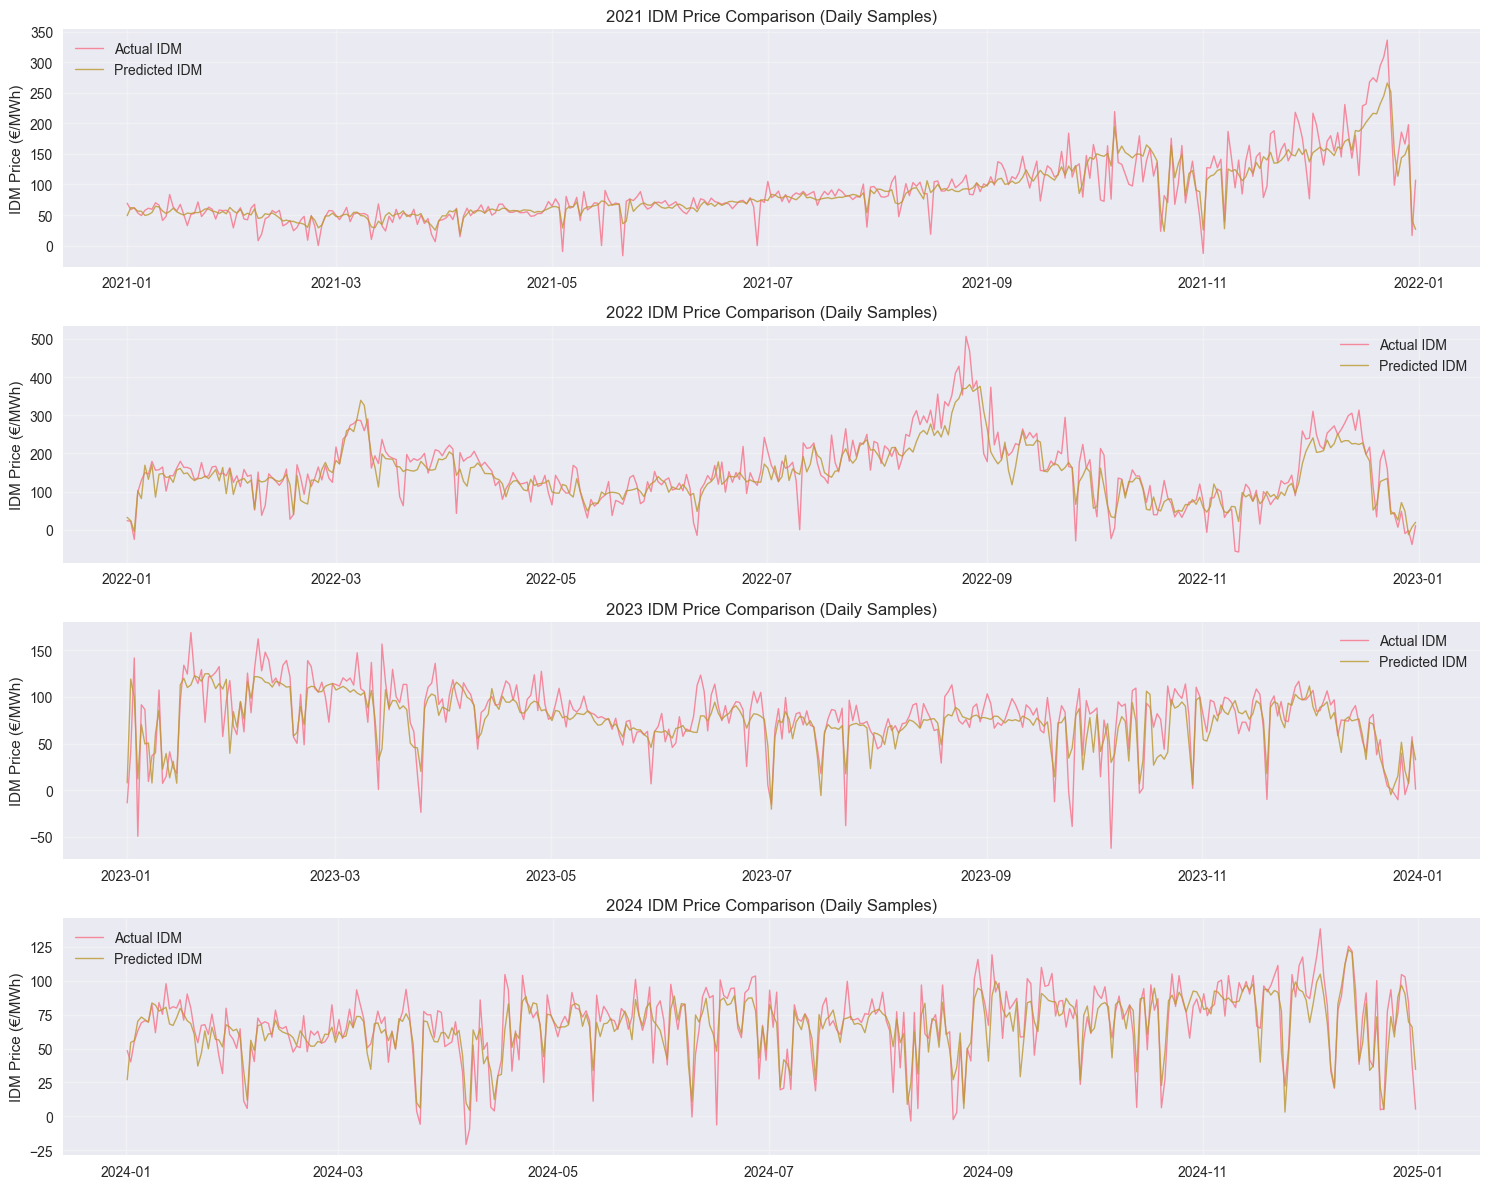

In [5]:
# Sample data for cleaner visualization (every 24 hours)
df_sample = df[::24].copy()

fig, axes = plt.subplots(len(df['year'].unique()), 1, figsize=(15, 3*len(df['year'].unique())))
if len(df['year'].unique()) == 1:
    axes = [axes]

for i, year in enumerate(sorted(df['year'].unique())):
    year_data = df_sample[df_sample['year'] == year]
    
    axes[i].plot(year_data['datetime'], year_data['actual_idm'], 
                label='Actual IDM', alpha=0.8, linewidth=1)
    axes[i].plot(year_data['datetime'], year_data['predicted_idm'], 
                label='Predicted IDM', alpha=0.8, linewidth=1)
    
    axes[i].set_ylabel('IDM Price (€/MWh)')
    axes[i].set_title(f'{year} IDM Price Comparison (Daily Samples)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Error Analysis

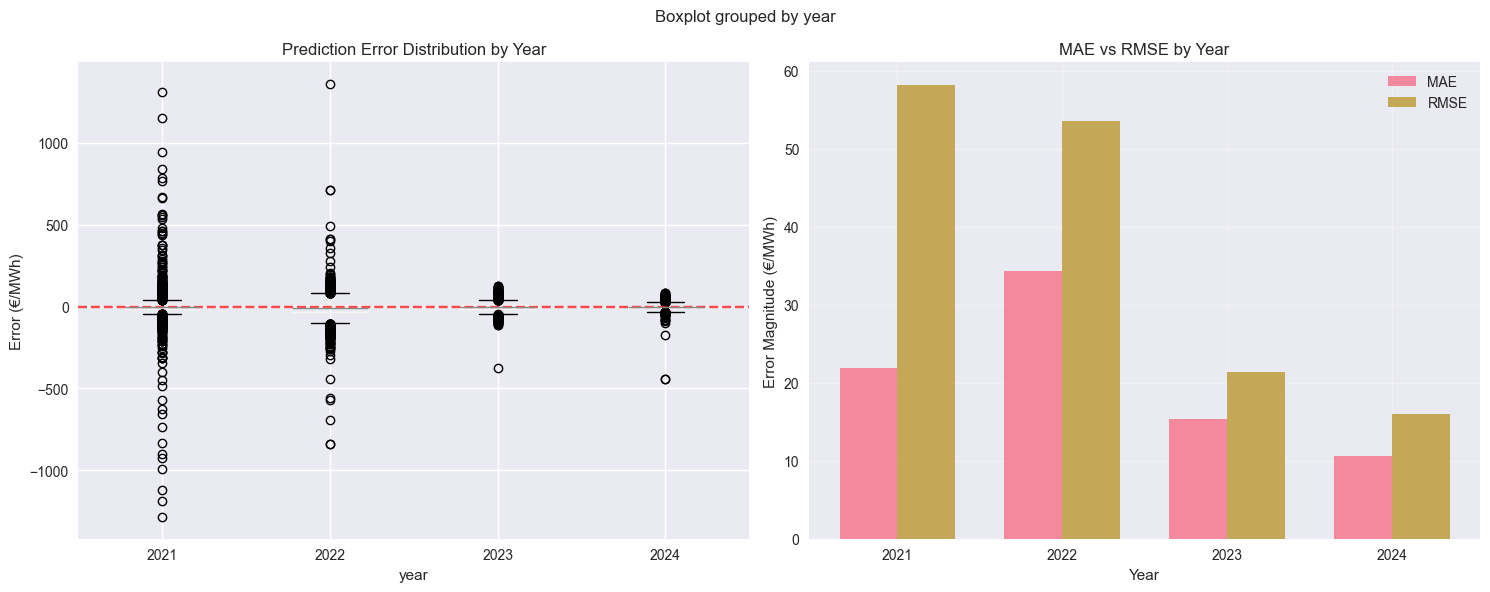

In [6]:
# Calculate prediction errors
df['error'] = df['predicted_idm'] - df['actual_idm']
df['abs_error'] = np.abs(df['error'])

# Error distribution by year
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot of errors
df.boxplot(column='error', by='year', ax=axes[0])
axes[0].set_title('Prediction Error Distribution by Year')
axes[0].set_ylabel('Error (€/MWh)')
axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.7)

# Error metrics comparison
x = range(len(metrics_df))
width = 0.35

axes[1].bar([i - width/2 for i in x], metrics_df['MAE'], width, label='MAE', alpha=0.8)
axes[1].bar([i + width/2 for i in x], metrics_df['RMSE'], width, label='RMSE', alpha=0.8)

axes[1].set_xlabel('Year')
axes[1].set_ylabel('Error Magnitude (€/MWh)')
axes[1].set_title('MAE vs RMSE by Year')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_df['Year'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Overall Performance Summary

In [7]:
# Overall metrics across all years
overall_mae = mean_absolute_error(df['actual_idm'], df['predicted_idm'])
overall_rmse = np.sqrt(mean_squared_error(df['actual_idm'], df['predicted_idm']))
overall_r2 = r2_score(df['actual_idm'], df['predicted_idm'])

print("=== OVERALL PERFORMANCE SUMMARY ===")
print(f"Total Records: {len(df):,}")
print(f"Years Analyzed: {', '.join(map(str, sorted(df['year'].unique())))}")
print(f"\nOverall Metrics:")
print(f"  Mean Absolute Error (MAE): {overall_mae:.2f} €/MWh")
print(f"  Root Mean Square Error (RMSE): {overall_rmse:.2f} €/MWh")
print(f"  Coefficient of Determination (R²): {overall_r2:.3f}")

print(f"\nBest Performance by Metric:")
best_mae_year = metrics_df.loc[metrics_df['MAE'].idxmin(), 'Year']
best_rmse_year = metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Year']
best_r2_year = metrics_df.loc[metrics_df['R²'].idxmax(), 'Year']

print(f"  Lowest MAE: {best_mae_year} ({metrics_df.loc[metrics_df['MAE'].idxmin(), 'MAE']:.2f} €/MWh)")
print(f"  Lowest RMSE: {best_rmse_year} ({metrics_df.loc[metrics_df['RMSE'].idxmin(), 'RMSE']:.2f} €/MWh)")
print(f"  Highest R²: {best_r2_year} ({metrics_df.loc[metrics_df['R²'].idxmax(), 'R²']:.3f})")

=== OVERALL PERFORMANCE SUMMARY ===
Total Records: 35,058
Years Analyzed: 2021, 2022, 2023, 2024

Overall Metrics:
  Mean Absolute Error (MAE): 20.53 €/MWh
  Root Mean Square Error (RMSE): 41.74 €/MWh
  Coefficient of Determination (R²): 0.775

Best Performance by Metric:
  Lowest MAE: 2024 (10.62 €/MWh)
  Lowest RMSE: 2024 (16.00 €/MWh)
  Highest R²: 2022 (0.745)
